In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  # Remove useless words
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form; aggressive

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
set(stopwords.words('english'))


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Load Dataset 

In [3]:
data = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/train.csv')

In [4]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## Pre-Processing Data

In [6]:
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

remove_n = lambda x: re.sub("\n", " ", x)

remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)


In [7]:
data.comment_text.head()

0    explanation why the edits made under my userna...
1    d aww  he matches this background colour i m s...
2    hey man  i m really not trying to edit war  it...
3      more i can t make any real suggestions on im...
4    you  sir  are my hero  any chance you remember...
Name: comment_text, dtype: object

## Exploratory Data Analysis

In [8]:
data.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

In [9]:
toxic_feat=data.iloc[:,2:].sum()

In [10]:
toxic_feat

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [11]:
num_rows = len(data)
print(num_rows)

159571


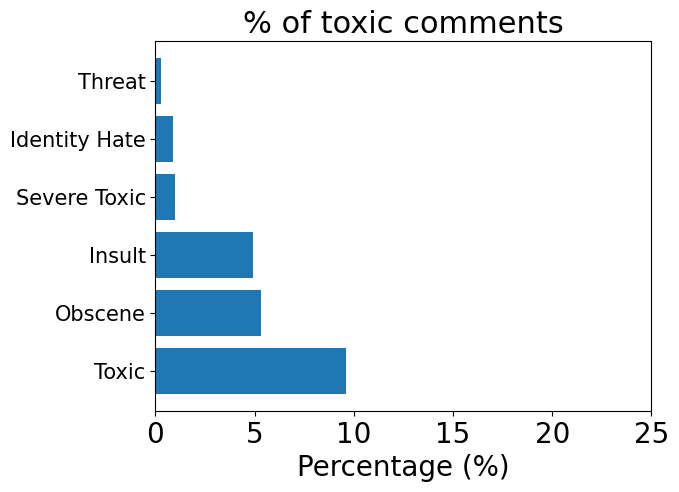

In [12]:
tox_per = data['toxic'].sum() / num_rows * 100
sevTox_per = data['severe_toxic'].sum() / num_rows * 100
obs_per = data['obscene'].sum() / num_rows * 100
thr_per = data['threat'].sum() / num_rows * 100
ins_per = data['insult'].sum() / num_rows * 100
hate_per = data['identity_hate'].sum() / num_rows * 100


ind = np.arange(6)

graph = plt.barh(ind, [tox_per, obs_per, ins_per, sevTox_per, hate_per, thr_per])
plt.xlabel('Percentage (%)', size=20)
plt.title('% of toxic comments', size=22)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

plt.show()

### Creating WordCloud
Useful to show the words which occur most frequently for each category.

In [13]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

### Separate our dataset into 6 sections. Each section is comment + 1 toxic feature

In [14]:
data_tox = data.loc[:,['id','comment_text','toxic']]

In [15]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [16]:
data_obs = data.loc[:,['id','comment_text','obscene']]

In [17]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [18]:
data_ins = data.loc[:,['id','comment_text','insult']]

In [19]:
data_ide = data.loc[:,['id','comment_text','identity_hate']]

In [20]:
def wordcloud(df, label):
    
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

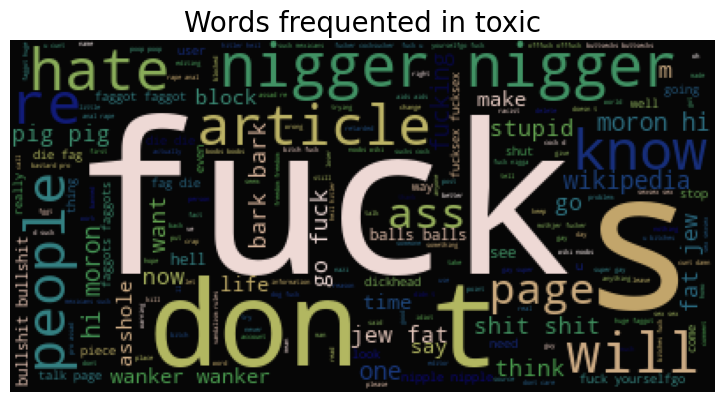

In [21]:
wordcloud(data_tox, 'toxic')

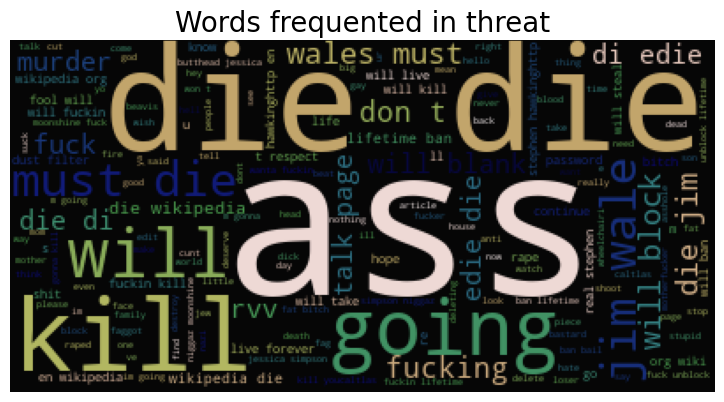

In [22]:
wordcloud(data_thr, 'threat')

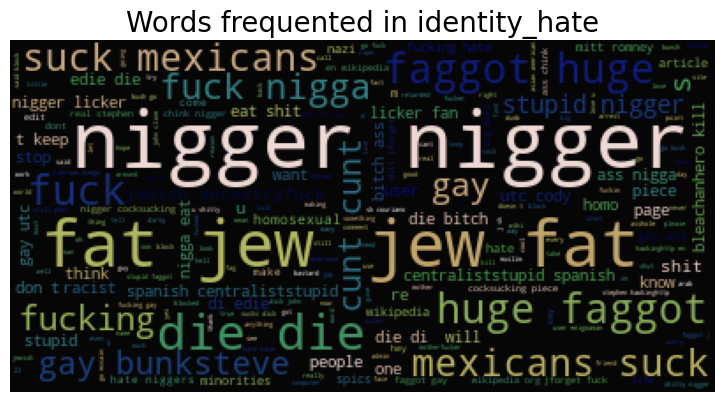

In [23]:
wordcloud(data_ide,'identity_hate')

## Data Process

In [24]:
data_isToxic = data_tox[data_tox['toxic'] == 1].iloc[:5000,:]
data_nonToic = data_tox[data_tox['toxic'] == 0].iloc[:5000, :]

In [25]:
data_Toxic = pd.concat([data_isToxic, data_nonToic], axis=0)
data_Toxic.shape

(10000, 3)

As all categories are not having 5000rows. So we should count them first and make them balanced.

In [26]:
data_sev[data_sev['severe_toxic'] == 1].count()

id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [27]:
data_isSev = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_nonSev = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_severeToxic = pd.concat([data_isSev, data_nonSev], axis=0)
data_severeToxic.shape

(3190, 3)

In [28]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [29]:
data_isObs = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_nonObs = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_Obsence = pd.concat([data_isObs, data_nonObs], axis=0)
data_Obsence.shape

(10000, 3)

In [30]:
data_thr[data_thr['threat'] == 1].count()


id              478
comment_text    478
threat          478
dtype: int64

In [31]:
data_isThr = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_nonThr = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_Threat = pd.concat([data_isThr, data_nonThr], axis=0)
data_Threat.shape

(2390, 3)

In [32]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [33]:
data_isIns = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_nonIns = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_Insult = pd.concat([data_isIns, data_nonIns], axis=0)
data_Insult.shape

(10000, 3)

In [34]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [35]:
data_isIde = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_nonIde = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_Hate = pd.concat([data_isIde, data_nonIde], axis=0)
data_Hate.shape

(7025, 3)

## Model Training

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [37]:
def model_train(data_toxicFeat,label,vectorizer,ngram):
    
    ''' Train/Test split'''
    X = data_toxicFeat.comment_text
    y = data_toxicFeat[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''
    vect = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect  = vect.transform(X_test)     

    lr = LogisticRegression()
    lr.fit(X_train_vect, y_train)
    print('logisticRegression done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_vect, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_vect, y_train)
    print('BernoulliNB done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_vect, y_train)
    print('MultiNominal done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_vect, y_train)
    print('SupportVectorClassifier done')

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_vect, y_train)
    print('RandomForest done')

    f1_score_data = {'F1 Score ({})'.format(label):[f1_score(lr.predict(X_test_vect), y_test), 
                                f1_score(knn.predict(X_test_vect), y_test), 
                                f1_score(bnb.predict(X_test_vect), y_test), 
                                f1_score(mnb.predict(X_test_vect), y_test),
                                f1_score(svm_model.predict(X_test_vect), y_test), 
                                f1_score(randomforest.predict(X_test_vect), y_test)]} 
    
    
    precision_score_data = {'precision Score ({})'.format(label):[precision_score(lr.predict(X_test_vect), y_test), 
                                precision_score(knn.predict(X_test_vect), y_test), 
                                precision_score(bnb.predict(X_test_vect), y_test), 
                                precision_score(mnb.predict(X_test_vect), y_test),
                                precision_score(svm_model.predict(X_test_vect), y_test), 
                                precision_score(randomforest.predict(X_test_vect), y_test)]} 


    recall_score_data = {'recall Score ({})'.format(label):[recall_score(lr.predict(X_test_vect), y_test), 
                                recall_score(knn.predict(X_test_vect), y_test), 
                                recall_score(bnb.predict(X_test_vect), y_test), 
                                recall_score(mnb.predict(X_test_vect), y_test),
                                recall_score(svm_model.predict(X_test_vect), y_test), 
                                recall_score(randomforest.predict(X_test_vect), y_test)]} 
                          
    data_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  
    data_precision = pd.DataFrame(precision_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  
    data_recall = pd.DataFrame(recall_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return data_f1, data_precision, data_recall
     

In [38]:
import time

t0 = time.time()

df_tox = model_train(data_Toxic, 'toxic', TfidfVectorizer, (1,1))


# t1 = time.time()

# total = 'Time taken: {} seconds'.format(t1-t0)
# print(total)

df_tox

logisticRegression done
BernoulliNB done
MultiNominal done
SupportVectorClassifier done
RandomForest done


(                F1 Score (toxic)
 Log Regression          0.861234
 KNN                     0.151079
 BernoulliNB             0.776521
 MultinomialNB           0.874958
 SVM                     0.876133
 Random Forest           0.838055,
                 precision Score (toxic)
 Log Regression                 0.821731
 KNN                            0.080677
 BernoulliNB                    0.938191
 MultinomialNB                  0.849057
 SVM                            0.849057
 Random Forest                  0.779440,
                 recall Score (toxic)
 Log Regression              0.904728
 KNN                         0.961240
 BernoulliNB                 0.662379
 MultinomialNB               0.902490
 SVM                         0.904993
 Random Forest               0.906203)

In [39]:
t0 = time.time()

df_sev = model_train(data_severeToxic, 'severe_toxic', TfidfVectorizer, (1,1))

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_sev

logisticRegression done
BernoulliNB done
MultiNominal done
SupportVectorClassifier done
RandomForest done
Time taken: 1.1110568046569824 seconds


(                F1 Score (severe_toxic)
 Log Regression                 0.927879
 KNN                            0.857143
 BernoulliNB                    0.803707
 MultinomialNB                  0.936170
 SVM                            0.926004
 Random Forest                  0.934874,
                 precision Score (severe_toxic)
 Log Regression                        0.896050
 KNN                                   0.929314
 BernoulliNB                           0.991684
 MultinomialNB                         0.960499
 SVM                                   0.910603
 Random Forest                         0.925156,
                 recall Score (severe_toxic)
 Log Regression                     0.962054
 KNN                                0.795374
 BernoulliNB                        0.675637
 MultinomialNB                      0.913043
 SVM                                0.941935
 Random Forest                      0.944798)

In [40]:
t0 = time.time()

df_obs = model_train(data_Obsence, 'obscene', TfidfVectorizer, (1,1))

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs

logisticRegression done
BernoulliNB done
MultiNominal done
SupportVectorClassifier done
RandomForest done
Time taken: 6.372869968414307 seconds


(                F1 Score (obscene)
 Log Regression            0.908655
 KNN                       0.244318
 BernoulliNB               0.787830
 MultinomialNB             0.901463
 SVM                       0.921378
 Random Forest             0.909091,
                 precision Score (obscene)
 Log Regression                   0.864021
 KNN                              0.139232
 BernoulliNB                      0.951854
 MultinomialNB                    0.901757
 SVM                              0.895901
 Random Forest                    0.878334,
                 recall Score (obscene)
 Log Regression                0.958153
 KNN                           0.963964
 BernoulliNB                   0.672026
 MultinomialNB                 0.901170
 SVM                           0.948347
 Random Forest                 0.942080)

In [41]:
t0 = time.time()

df_thr = model_train(data_Threat, 'threat', TfidfVectorizer, (1,1))

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr

logisticRegression done
BernoulliNB done
MultiNominal done
SupportVectorClassifier done
RandomForest done
Time taken: 0.8750457763671875 seconds


(                F1 Score (threat)
 Log Regression           0.628821
 KNN                      0.720000
 BernoulliNB              0.311828
 MultinomialNB            0.504762
 SVM                      0.786765
 Random Forest            0.795539,
                 precision Score (threat)
 Log Regression                  0.467532
 KNN                             0.642857
 BernoulliNB                     0.188312
 MultinomialNB                   0.344156
 SVM                             0.694805
 Random Forest                   0.694805,
                 recall Score (threat)
 Log Regression               0.960000
 KNN                          0.818182
 BernoulliNB                  0.906250
 MultinomialNB                0.946429
 SVM                          0.906780
 Random Forest                0.930435)

In [42]:
t0 = time.time()

df_ins = model_train(data_Insult, 'insult', TfidfVectorizer, (1,1))

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins

logisticRegression done
BernoulliNB done
MultiNominal done
SupportVectorClassifier done
RandomForest done
Time taken: 6.495018005371094 seconds


(                F1 Score (insult)
 Log Regression           0.896599
 KNN                      0.225287
 BernoulliNB              0.783762
 MultinomialNB            0.897411
 SVM                      0.902619
 Random Forest            0.883993,
                 precision Score (insult)
 Log Regression                  0.857515
 KNN                             0.127521
 BernoulliNB                     0.942095
 MultinomialNB                   0.890696
 SVM                             0.874431
 Random Forest                   0.835394,
                 recall Score (insult)
 Log Regression               0.939416
 KNN                          0.965517
 BernoulliNB                  0.670992
 MultinomialNB                0.904227
 SVM                          0.932686
 Random Forest                0.938596)

In [43]:
t0 = time.time()

df_ide = model_train(data_Hate, 'identity_hate', TfidfVectorizer, (1,1))


t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide

logisticRegression done
BernoulliNB done
MultiNominal done
SupportVectorClassifier done
RandomForest done
Time taken: 4.1429712772369385 seconds


(                F1 Score (identity_hate)
 Log Regression                  0.699029
 KNN                             0.161826
 BernoulliNB                     0.549206
 MultinomialNB                   0.485857
 SVM                             0.797516
 Random Forest                   0.768448,
                 precision Score (identity_hate)
 Log Regression                         0.572727
 KNN                                    0.088636
 BernoulliNB                            0.393182
 MultinomialNB                          0.331818
 SVM                                    0.729545
 Random Forest                          0.686364,
                 recall Score (identity_hate)
 Log Regression                      0.896797
 KNN                                 0.928571
 BernoulliNB                         0.910526
 MultinomialNB                       0.906832
 SVM                                 0.879452
 Random Forest                       0.872832)

In [44]:
f1_all = pd.concat([df_tox[0], df_sev[0], df_obs[0], df_ins[0], df_thr[0], df_ide[0]], axis=1)
f1_all

,F1 Score (toxic),F1 Score (severe_toxic),F1 Score (obscene),F1 Score (insult),F1 Score (threat),F1 Score (identity_hate)
Log Regression,0.861234,0.927879,0.908655,0.896599,0.628821,0.699029
KNN,0.151079,0.857143,0.244318,0.225287,0.720000,0.161826
BernoulliNB,0.776521,0.803707,0.787830,0.783762,0.311828,0.549206
MultinomialNB,0.874958,0.936170,0.901463,0.897411,0.504762,0.485857
SVM,0.876133,0.926004,0.921378,0.902619,0.786765,0.797516
Random Forest,0.838055,0.934874,0.909091,0.883993,0.795539,0.768448


In [45]:
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score (toxic),0.861234,0.151079,0.776521,0.874958,0.876133,0.838055
F1 Score (severe_toxic),0.927879,0.857143,0.803707,0.936170,0.926004,0.934874
F1 Score (obscene),0.908655,0.244318,0.787830,0.901463,0.921378,0.909091
F1 Score (insult),0.896599,0.225287,0.783762,0.897411,0.902619,0.883993
F1 Score (threat),0.628821,0.720000,0.311828,0.504762,0.786765,0.795539
F1 Score (identity_hate),0.699029,0.161826,0.549206,0.485857,0.797516,0.768448


In [46]:
Precision_all = pd.concat([df_tox[1], df_sev[1], df_obs[1], df_ins[1], df_thr[1], df_ide[1]], axis=1)
Precision_all

,precision Score (toxic),precision Score (severe_toxic),precision Score (obscene),precision Score (insult),precision Score (threat),precision Score (identity_hate)
Log Regression,0.821731,0.896050,0.864021,0.857515,0.467532,0.572727
KNN,0.080677,0.929314,0.139232,0.127521,0.642857,0.088636
BernoulliNB,0.938191,0.991684,0.951854,0.942095,0.188312,0.393182
MultinomialNB,0.849057,0.960499,0.901757,0.890696,0.344156,0.331818
SVM,0.849057,0.910603,0.895901,0.874431,0.694805,0.729545
Random Forest,0.779440,0.925156,0.878334,0.835394,0.694805,0.686364


In [47]:
Precision_all_trp = Precision_all.transpose()
Precision_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
precision Score (toxic),0.821731,0.080677,0.938191,0.849057,0.849057,0.779440
precision Score (severe_toxic),0.896050,0.929314,0.991684,0.960499,0.910603,0.925156
precision Score (obscene),0.864021,0.139232,0.951854,0.901757,0.895901,0.878334
precision Score (insult),0.857515,0.127521,0.942095,0.890696,0.874431,0.835394
precision Score (threat),0.467532,0.642857,0.188312,0.344156,0.694805,0.694805
precision Score (identity_hate),0.572727,0.088636,0.393182,0.331818,0.729545,0.686364


In [48]:
Recall_all = pd.concat([df_tox[2], df_sev[2], df_obs[2], df_ins[2], df_thr[2], df_ide[2]], axis=1)
Recall_all

,recall Score (toxic),recall Score (severe_toxic),recall Score (obscene),recall Score (insult),recall Score (threat),recall Score (identity_hate)
Log Regression,0.904728,0.962054,0.958153,0.939416,0.960000,0.896797
KNN,0.961240,0.795374,0.963964,0.965517,0.818182,0.928571
BernoulliNB,0.662379,0.675637,0.672026,0.670992,0.906250,0.910526
MultinomialNB,0.902490,0.913043,0.901170,0.904227,0.946429,0.906832
SVM,0.904993,0.941935,0.948347,0.932686,0.906780,0.879452
Random Forest,0.906203,0.944798,0.942080,0.938596,0.930435,0.872832


In [49]:
Recall_all_trp = Recall_all.transpose()
Recall_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
recall Score (toxic),0.904728,0.961240,0.662379,0.902490,0.904993,0.906203
recall Score (severe_toxic),0.962054,0.795374,0.675637,0.913043,0.941935,0.944798
recall Score (obscene),0.958153,0.963964,0.672026,0.901170,0.948347,0.942080
recall Score (insult),0.939416,0.965517,0.670992,0.904227,0.932686,0.938596
recall Score (threat),0.960000,0.818182,0.906250,0.946429,0.906780,0.930435
recall Score (identity_hate),0.896797,0.928571,0.910526,0.906832,0.879452,0.872832


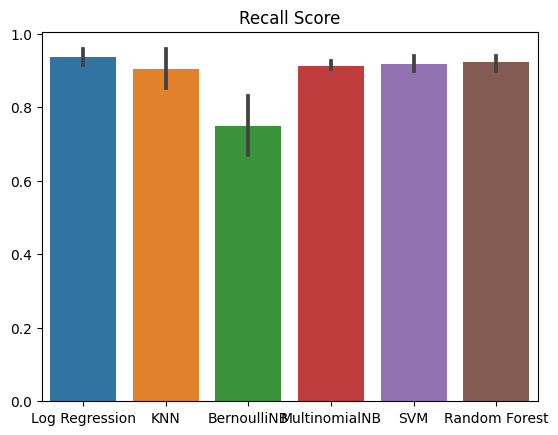

In [50]:
sns.barplot(Recall_all_trp)
plt.title('Recall Score')
plt.show()

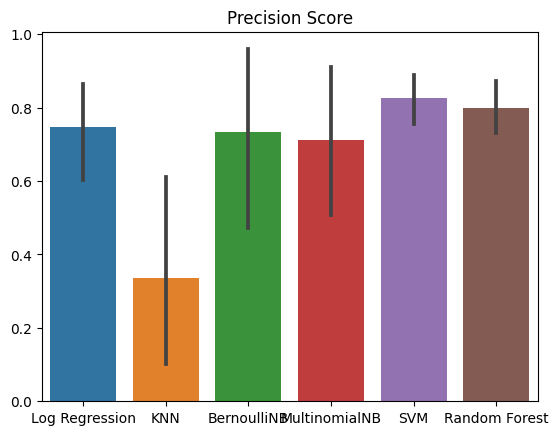

In [51]:
sns.barplot(Precision_all_trp)
plt.title('Precision Score')
plt.show()

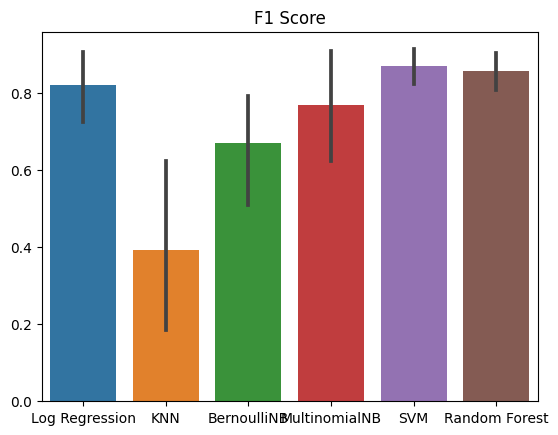

In [52]:
sns.barplot(f1_all_trp)
plt.title('F1 Score')
plt.show()

### As we know now that Random Forest performs best among all clssification model, lets build pipeline using TfidfVectorizer and randmForest

In [55]:
data[data['toxic'] == 1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
12,0005c987bdfc9d4b,hey what is it talk what is it a...,1,0,0,0,0,0
16,0007e25b2121310b,bye don t look come or think of comming ba...,1,0,0,0,0,0
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1,0,1,0,1,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,our previous conversation you fucking sh...,1,0,1,0,1,1
159514,ff39a2895fc3b40e,you are a mischievious pubic hair,1,0,0,0,1,0
159541,ffa33d3122b599d6,your absurd edits your absurd edits on great...,1,0,1,0,1,0
159546,ffb47123b2d82762,hey listen don t you ever delete my edi...,1,0,0,0,1,0


In [82]:
db_toxic = data.loc[:,['comment_text', 'toxic']]

In [83]:
db_toxic.sample(10)

,comment_text,toxic
127875,a memory location jumping into data caused an...,0
38243,sockpuppetry case you have been accused o...,0
139819,pointing out that your behavior is in viola...,0
151009,a higher honor not given to the ss john w b...,0
118317,me too i listen to the album everyday hey ...,0
4553,note you do not need to be a member of this p...,0
119193,april utc and now it s gone,0
71642,good i am going to tell them about you harra...,0
61603,no you just repeatedly fucked up an article f...,1
136623,the footnote at the end of the paragraph cover...,0


In [84]:
db_toxic.shape

(159571, 2)

In [85]:
db_toxic.toxic.sum()

15294

In [86]:
db_Toxic = db_toxic[db_toxic['toxic'] == 1].iloc[0:15000,:]
db_nonToxic = db_toxic[db_toxic['toxic'] == 0].iloc[0:15000,:]

In [88]:
toxic_dataset = pd.concat([db_Toxic, db_nonToxic], axis=0)

In [89]:
toxic_dataset.shape

(30000, 2)

## Building Pipeline

In [91]:
from sklearn.pipeline import Pipeline

In [92]:
X = toxic_dataset['comment_text']
y = toxic_dataset['toxic']

X_train, X_text, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

steps = [('vectorizer' , TfidfVectorizer(ngram_range=(1,1), stop_words='english')),
        ('randomForest', RandomForestClassifier(n_estimators=100, random_state=42))]

In [94]:
pipe = Pipeline(steps) 
steps

[('vectorizer', TfidfVectorizer(stop_words='english')),
 ('randomForest', RandomForestClassifier(random_state=42))]

In [95]:
pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('randomForest', RandomForestClassifier(random_state=42))])

In [96]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('randomForest', RandomForestClassifier(random_state=42))])

In [97]:
y_pred = pipe.predict(X_text)

In [98]:
y_pred

array([1, 0, 0, ..., 1, 1, 0])

In [103]:
f1Score = f1_score(y_test, y_pred)
print(f'F1 Score : {f1Score}')

preScore = precision_score(y_test,y_pred)
print(f'Precision Score : {preScore}')

recallScore = recall_score(y_test,y_pred)
print(f'Recall Score : {recallScore}')

F1 Score : 0.8534025238825333
Precision Score : 0.9227237949502678
Recall Score : 0.7937691970162352


In [104]:
from sklearn.metrics import accuracy_score
accu = accuracy_score(y_test, y_pred)
print("Accuracy Score :", accu)

Accuracy Score : 0.8618888888888889


## Saving Model

In [105]:
import pickle

with open('ToxicityAnalyzer-0.1.0.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [124]:
text = "how are you"
y = pipe.predict([text])

y[0]

0